In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mnist import MNIST
import libsvm.svmutil as svmlib

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import random



### Normalize

In [3]:
def normalize(train, test):
    scaler = StandardScaler()
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)
    return train, test

### PCA

In [4]:
def my_pca(train, test, pc=2, type='sklearn', var=None):
    '''
    take raw data and reduce it down to n pc components
    train: input features, np array, data only without column names or labels
    test: test set, similar data to train
    pc: number of principal components
    type: inbuilt or own implementation
    var: target variance. how much of variance should be accounted for by PCs
    '''
    if type == 'sklearn':
        # # normalize train and test data
        # scaler = StandardScaler()
        # scaler.fit(train)
        # train = scaler.transform(train)
        # test = scaler.transform(test)
        # if variance based #pc is selected, use that
        if var != None:
            pca = PCA(var)
        else:
            pca = PCA(n_components=pc)
        # perform actual pca on train and test data
        pca.fit(train)
        train = pca.transform(train)
        test = pca.transform(test)
        # print the number of PCs of the new data
        # print(f"pca contains {pca.explained_variance_ratio_*100}% of the variance")
        print(f"number of principal components {pca.n_components_}")

        # this is for speed fp64 -> fp16. otherwise there is hardly any benefit
        train = train.astype(np.float16)
        test = test.astype(np.float16)

        return train, test
    elif type == 'numpy':
        pass
    else:
        return ("invalid type")


### Kernel for SVM

In [6]:
def linear_kernel(s=0, t=0):
    return svmlib.svm_parameter('-s {} -t {}'.format(s, t))
def poly_kernel(s=0, t=1, d=3):
    return svmlib.svm_parameter('-s {} -t {} -d {}'.format(s, t, d))
def rbf_kernel(s=0, t=2, c=1000, g=2):
    return svmlib.svm_parameter('-s {} -t {} -c {} -g {}'.format(s, t, c, g))

### SVM

In [7]:
def svm_train(labels, data, kernel="linear", kernel_config=None):
    '''
    train an svm classifier and return the model
    '''
    
    if kernel_config != None:
        d = kernel_config.get('d')
        c = kernel_config.get('c')
        g = kernel_config.get('g')
    else:
        d = 3
        c = 1000
        g = 0.001     
    print(f"d {d} c {c} g {g}")
    problem = svmlib.svm_problem(labels, data)
    
    # set kernel type
    # set kernel arguments from kernel_config argument
    if kernel == "linear":
        param = linear_kernel(s=0, t=0)
    elif kernel == "polynomial":
        param = poly_kernel(s=0, t=1, d=d)
    elif kernel == "rbf":
        param = rbf_kernel(s=0, t=2, c=c, g=g)
    
    # train the classifier model
    classifier = svmlib.svm_train(problem, param)

    return classifier

def svm_predict(classifier, labels, data):
    '''
    use the trained svm classifier to make predictions
    '''
    p_labs, p_acc, p_vals = svmlib.svm_predict(labels, data, classifier)
    # print("accuracy:", p_acc)
    # for pred, true in zip(p_labs, label):
    #     print("true: {} pred: {}".format(true, pred))
    return p_labs, p_acc

### Logistic Regression

In [8]:
def logistic_regression_train(labels, data):
    '''
    train a logistic regression classifier
    '''
    logistic = LogisticRegression(solver = 'lbfgs', max_iter=5000, multi_class='multinomial')
    logistic.fit(data, labels)
    return logistic

def logistic_regression_predict(classifier, labels, data):
    '''
    make predictions using a logistic regression classifier
    '''
    p_labs = classifier.predict(data)
    score = classifier.score(data, labels)
    return p_labs, score



### Pytorch MNIST Setup

In [9]:
# def mnist_for_torch(in_train):
#     a=torch.tensor(in_train).reshape((-1, 28, 28)).type(torch.uint8)
#     return a
def torch_mnist_cnn_setup():
    train_data = datasets.MNIST(
        root = 'data',
        train = True,
        transform = ToTensor(),
        download = True,
    )
    test_data = datasets.MNIST(
        root = 'data',
        train = False,
        transform = ToTensor(),
    )

    loaders = {
        'train': DataLoader(
            train_data,
            batch_size=100,
            shuffle = True,
            num_workers = 1,
        ),
        'test': DataLoader(
            test_data,
            batch_size = 100,
            shuffle = True,
            num_workers = 1,
        )
    }
    return train_data, test_data, loaders


### ConvNet Setup

In [10]:
class CNN(nn.Module):
    '''
    the is the structure neural network
    => input(28x28) 
    -> conv(5x5) -> relu -> pool(2,2) 
    -> conv(5x5) -> relu -> pool(2,2)
    -> fc(32*7x7,10)
    => softmax(10)
    '''
    def __init__(self):
        super(CNN, self).__init__()
        # conv(5x5) -> relu -> pool(2,2) 
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 1,
                out_channels = 16,
                kernel_size = 5,
                stride = 1,
                padding = 2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # conv(5x5) -> relu -> pool(2,2) 
        self.conv2=nn.Sequential(
            nn.Conv2d(
                in_channels = 16,
                out_channels = 32,
                kernel_size = 5, 
                stride = 1, 
                padding = 2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fc(32*7x7,10)
        self.out=nn.Linear(32*7*7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x

loss_func=nn.CrossEntropyLoss()

### CNN

In [85]:
def cnn_train(loaders, train_epochs=10, learning_rate=0.01):
    '''
    takes a loaders object
    this will provide labels and data in minibatches as it trains a cnn written in pytorch
    A trained classifer (cnn) will be returned
    some setup has already been done for the data so that it is torch friendly
    '''
    # Training Progress Display Setup
    f_string = 'Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
    
    def train(num_epochs, cnn, loaders):
        cnn.train()
        total_step=len(loaders['train'])
        for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(loaders['train']):
                batch_x = Variable(images)
                batch_y = Variable(labels)
                output = cnn(batch_x)[0]
                loss = loss_func(output, batch_y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if (i+1) % 100 == 0:
                    print(f_string.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    # ConvNet Object
    cnn = CNN()
    # Set Optimizer
    optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
    # train for how long?
    num_epochs = train_epochs
    # train the ConvNet
    train(num_epochs, cnn, loaders)
    # return the trained classifier
    return cnn


def cnn_predict(classifier, loaders):
    def test():
        classifier.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in loaders['test']:
                test_output, last_layer = classifier(images)
                pred_y = torch.max(test_output, 1)[1].data.squeeze()
                accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        print("Accuracy: %.4f" % accuracy)
        return accuracy
    accuracy = test()
    return accuracy


### Import MNIST Data

In [86]:

mndata = MNIST('mnist')

train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

train_images = list(train_images)  # np.array(train_images)
train_labels = list(train_labels)  # np.array(train_labels)
test_images  = list(test_images)   # np.array(test_images)
test_labels  = list(test_labels)   # np.array(test_labels)

nptrain_images = np.array(train_images)  # np.array(train_images)
nptrain_labels = np.array(train_labels)  # np.array(train_labels)
nptest_images  = np.array(test_images)   # np.array(test_images)
nptest_labels  = np.array(test_labels)   # np.array(test_labels)

# for pytorch
test_data, train_data, loaders = torch_mnist_cnn_setup()

### Data Samples

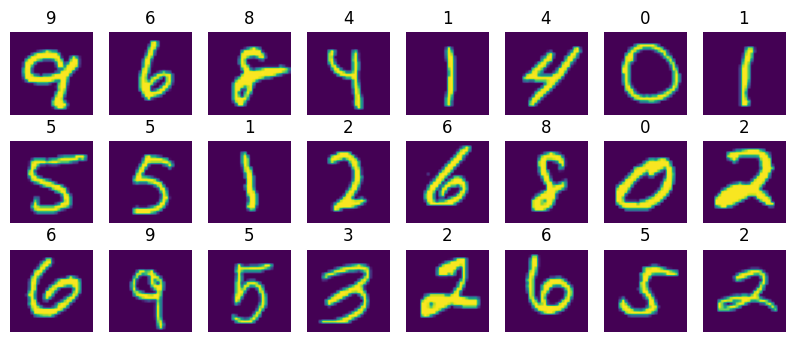

In [81]:
vis_train_images = nptrain_images.reshape((-1, 28, 28))
figure = plt.figure(figsize=(10, 4))
cols, rows = (8, 3)
for i in range(1, cols*rows+1):
  sample_idx=torch.randint(len(vis_train_images), size=(1,)).item()
  img, label=torch.tensor(vis_train_images[sample_idx]), train_labels[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.axis("off")
  plt.imshow(img.squeeze())
plt.show()

### Run this cell to undo PCA

In [87]:
# Init settings variables
normalize_data = None
dimensionality_reduction = None
model = None
kernel = None
data_reduced = False

### Pick Classification Settings and Train Classifier

In [101]:
# normalization required
#   True
#   False
normalize_data = True
# normalize_data = False

# pick the dimensionality reduction:
#   PCA
#   LDA/MDA
#   None
dimensionality_reduction = "pca"
# dimensionality_reduction = "lda"

# pick the type of classifier model:
#   svm
#   logistic
#   cnn
# model = "svm"
# model = "logistic"
model = "cnn"

# pick kernel type
#   linear
#   polynomial
#   rbf
kernel = "linear"
# kernel = "polynomial"
# kernel = "rbf"

# train, test separate

# normalize test and train data
if normalize_data == True:
    print("normalize")
    train_images, test_images = normalize(train_images, test_images)

# dimensionality reduction on test and train data
if data_reduced == False:
    if dimensionality_reduction == "pca":
        print("pca")
        train_images, test_images = my_pca(train_images, test_images, pc=50)
        # this specifies PCA components by desired variance (pc=x is ignored)
        # train_images, test_images = my_pca(train_images, test_images, pc=100, var=.85)
        data_reduced = True
    elif dimensionality_reduction == "lda":
        print("lda")
        data_reduced = True
        pass
    else:
        print("dimensionality reduction not selected")
else:
    print(f"dimensions already reduced using {dimensionality_reduction} to {len(train_images[0])} components")

# train - svm, logistic, CNN
if model == "svm":
    print("svm")
    # train batch
    n = 10000
    train = train_images[:n]
    label = train_labels[:n]
    # random_sample = random.sample(range(60000), n)
    # train = nptrain_images[random_sample]
    # label = nptrain_labels[random_sample]
    # full train set
    # train = train_images
    # label = train_labels
    classifier = svm_train(label, train, kernel, kernel_config={'d':10, 'c':1000, 'g':0.01})
elif model == "logistic":
    print("logistic")
    # train batch
    n = 10000
    train = train_images[:n]
    label = train_labels[:n]
    # full train set
    # train = train_images
    # label = train_labels
    classifier = logistic_regression_train(label, train)
elif model == "cnn":
    print("cnn")
    classifier = cnn_train(loaders, train_epochs=10)
else:
    print("classifier model not selected")
print("classifier trained")


normalize
dimensions already reduced using pca to 50 components
cnn
Epoch [1/10], Step [100/600], Loss: 0.0323
Epoch [1/10], Step [200/600], Loss: 0.1879
Epoch [1/10], Step [300/600], Loss: 0.0278
Epoch [1/10], Step [400/600], Loss: 0.0800
Epoch [1/10], Step [500/600], Loss: 0.0520
Epoch [1/10], Step [600/600], Loss: 0.0440
Epoch [2/10], Step [100/600], Loss: 0.0472
Epoch [2/10], Step [200/600], Loss: 0.0378
Epoch [2/10], Step [300/600], Loss: 0.0178
Epoch [2/10], Step [400/600], Loss: 0.0762
Epoch [2/10], Step [500/600], Loss: 0.0788
Epoch [2/10], Step [600/600], Loss: 0.0606
Epoch [3/10], Step [100/600], Loss: 0.0023
Epoch [3/10], Step [200/600], Loss: 0.0234
Epoch [3/10], Step [300/600], Loss: 0.0217
Epoch [3/10], Step [400/600], Loss: 0.0766
Epoch [3/10], Step [500/600], Loss: 0.0139
Epoch [3/10], Step [600/600], Loss: 0.0696
Epoch [4/10], Step [100/600], Loss: 0.0094
Epoch [4/10], Step [200/600], Loss: 0.0411
Epoch [4/10], Step [300/600], Loss: 0.0509
Epoch [4/10], Step [400/600],

### save trained for testing

In [104]:
torch.save(classifier, 'mnistcnn.pth')
# classifier = torch.load('mnistcnn.pth')

### Predict using the trained classifier model

In [105]:
# predict
if model == "svm":
    print("svm quality")
    # test batch
    # n = 3000
    # test = test_images[:n]
    # label = test_labels[:n]
    # test = test_images[:100]
    # label = test_labels[:100]
    
    # full test set
    test = test_images
    label = test_labels

    pred, scores = svm_predict(classifier, label, test)
    # p_labs, p_acc, p_vals = svmlib.svm_predict(label, test, classifier)


elif model == "logistic":
    print("logistic quality")
    # test batch
    # n = 1000
    # test = test_images[:n]
    # label = test_labels[:n]
   
    # full test set
    test = test_images
    label = test_labels
    pred, scores = logistic_regression_predict(classifier, label, test)
    
    print("Accuracy: {}%".format(scores*100))

elif model == "cnn":
    print("cnn quality")
    test = test_images
    label = test_labels
    cnn_predict(classifier, loaders)





cnn quality
Accuracy: 0.9800


In [106]:
if model == "svm":
    im, la = test_images[:20], test_labels[:20]
    pred, _ = svm_predict(classifier, la, im)
    print(f'predicted {pred[:20]}')
    print(f'actual    {np.array(la[:20])}')
if model == "logistic":
    im, la = test_images[:20], test_labels[:20]
    pred, _ = logistic_regression_predict(classifier, la, im)
if model == "cnn":
    print("cnn predict")
    im, la = next(iter(loaders['test']))
    to, ll = classifier(im)
    py = torch.max(to, 1)[1].data.numpy().squeeze()
    print(f'predicted {py[:20]}')
    print(f'actual    {np.array(la[:20])}')

cnn predict
predicted [6 5 9 5 3 5 9 5 0 1 6 4 8 7 5 3 0 3 9 7]
actual    [6 5 9 5 3 5 9 5 0 1 6 4 8 7 5 3 0 3 9 7]
